In [1]:
# Import Packages
import pandas as pd
import numpy as np
import os
import sys
import dtale
# import holidays
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from catboost import CatBoostClassifier
# from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

%matplotlib inline


# Folder Structure
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

# Read Data
train = pd.read_csv(f"{DATA_DIR}/train_wn75k28.csv")
test = pd.read_csv(f"{DATA_DIR}/test_Wf7sxXF.csv")

print(train.shape, test.shape)
train.sample()

(39161, 19) (13184, 18)


,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
4104,4105,2021-03-22,8,8,NaN,2022-01-25,0,0,1,0,1,1,0,0,0,0,0,0,0


In [2]:
train['campaign_var_1'].value_counts()

6     4061
5     4060
4     4018
3     3784
7     3756
2     3486
8     3407
9     2866
10    2392
11    1873
1     1593
12    1455
13    1059
14     714
15     456
16     181
Name: campaign_var_1, dtype: int64

In [3]:
test.sample()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12
9919,49081,2022-03-08,14,6,NaN,NaN,0,0,1,0,0,1,0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   created_at            39161 non-null  object 
 2   campaign_var_1        39161 non-null  int64  
 3   campaign_var_2        39161 non-null  int64  
 4   products_purchased    18250 non-null  float64
 5   signup_date           24048 non-null  object 
 6   user_activity_var_1   39161 non-null  int64  
 7   user_activity_var_2   39161 non-null  int64  
 8   user_activity_var_3   39161 non-null  int64  
 9   user_activity_var_4   39161 non-null  int64  
 10  user_activity_var_5   39161 non-null  int64  
 11  user_activity_var_6   39161 non-null  int64  
 12  user_activity_var_7   39161 non-null  int64  
 13  user_activity_var_8   39161 non-null  int64  
 14  user_activity_var_9   39161 non-null  int64  
 15  user_activity_var_1

In [5]:
train[['created_at', 'signup_date']].sample(5)

,created_at,signup_date
8427,2021-05-16,NaN
35989,2021-12-11,2020-01-14
815,2021-01-21,2021-05-20
30509,2021-11-06,2021-10-19
12644,2021-06-26,2019-06-10


In [6]:
# Convert date and hour fields to one datetime field.
datetime_cols = ['created_at', 'signup_date']
for col in datetime_cols:
    train[col] = pd.to_datetime(train[col], errors="coerce")
    test[col] = pd.to_datetime(test[col], errors="coerce")

train[['created_at', 'signup_date']].dtypes, test[['created_at', 'signup_date']].dtypes

(created_at     datetime64[ns]
 signup_date    datetime64[ns]
 dtype: object,
 created_at     datetime64[ns]
 signup_date    datetime64[ns]
 dtype: object)

In [7]:
# Feature Engineering
def datetime_disintegration(df, col):

    df[f"{col}_day"] = df[col].dt.day
    df[f"{col}_week"] = df[col].dt.isocalendar().week
    df[f"{col}_month"] = df[col].dt.month
    df[f"{col}_quarter"] = df[col].dt.quarter
    df[f"{col}_year"] = df[col].dt.year
    # df[f"{col}_hour"] = df[col].dt.hour
    # df[f"{col}_minute"] = df[col].dt.minute
    # df[f"{col}_second"] = df[col].dt.second
    df[f"{col}_weekday"] = df[col].dt.weekday
    # df[f"{col}_weekofyear"] = df[col].dt.weekofyear
    df[f"{col}_dayofyear"] = df[col].dt.dayofyear
    df[f"{col}_day_name"] = df[col].dt.day_name()
    df[f"{col}_is_month_start"] = df[col].dt.is_month_start
    df[f"{col}_is_month_end"] = df[col].dt.is_month_end
    df[f"{col}_is_quarter_start"] = df[col].dt.is_quarter_start
    df[f"{col}_is_quarter_end"] = df[col].dt.is_quarter_end
    df[f"{col}_is_year_start"] = df[col].dt.is_year_start
    df[f"{col}_is_year_end"] = df[col].dt.is_year_end
    df[f"{col}_is_leap_year"] = df[col].dt.is_leap_year
    df[f"{col}_days_in_month"] = df[col].dt.days_in_month
    
    return df


for col in datetime_cols:
    train_catboost = datetime_disintegration(train, col)
    test_catboost = datetime_disintegration(test, col)
    
    # del train_catboost[col]
    # del test_catboost[col]

train_catboost.sample()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,...,signup_date_dayofyear,signup_date_day_name,signup_date_is_month_start,signup_date_is_month_end,signup_date_is_quarter_start,signup_date_is_quarter_end,signup_date_is_year_start,signup_date_is_year_end,signup_date_is_leap_year,signup_date_days_in_month
24986,24987,2021-10-01,2,6,NaN,NaT,1,0,0,0,...,NaN,NaN,False,False,False,False,False,False,False,NaN


In [8]:
# pd.set_option('display.max_columns', None)


# train_catboost = train_catboost#.set_index(idx_cols)
# test_catboost = test_catboost#.set_index(idx_cols)

# train_catboost#.info()

In [9]:
# Select features for training
idx_cols = ['id', 'created_at', 'signup_date']

num_features = [
    'campaign_var_1', 'campaign_var_2', 'products_purchased',
    'user_activity_var_1', 'user_activity_var_2', 'user_activity_var_3',
    'user_activity_var_4', 'user_activity_var_5', 'user_activity_var_6',
    'user_activity_var_7', 'user_activity_var_8', 'user_activity_var_9',
    'user_activity_var_10', 'user_activity_var_11', 'user_activity_var_12',
    'created_at_day',
    # 'created_at_week',
    # 'created_at_month',
    # 'created_at_quarter', 
    # 'created_at_year', 
    'created_at_weekday',
    'created_at_dayofyear',
    'created_at_days_in_month',
    'signup_date_day',
    'signup_date_dayofyear',
    'signup_date_year', 'signup_date_weekday',
    'signup_date_days_in_month'
    # 'signup_date_week', 
    # 'signup_date_quarter',
    # 'signup_date_month',
]


cat_features = [
    'created_at_day_name', 
    'created_at_is_month_start', 'created_at_is_month_end',
    'created_at_is_quarter_start', 'created_at_is_quarter_end',
    'created_at_is_year_start', 'created_at_is_year_end',
    'created_at_is_leap_year', 
    'signup_date_day_name',
    'signup_date_is_month_start', 'signup_date_is_month_end',
    'signup_date_is_quarter_start', 'signup_date_is_quarter_end',
    'signup_date_is_year_start', 'signup_date_is_year_end',
    'signup_date_is_leap_year'
]


less_feature_imp = [
    'created_at_day_name', 'user_activity_var_3',
    'signup_date_is_leap_year', 'created_at_days_in_month',
    'created_at_is_quarter_end', 'created_at_quarter',
    'created_at_month', 'signup_date_is_quarter_start',
    'signup_date_is_month_start', 'created_at_is_quarter_start',
    'user_activity_var_12', 'signup_date_is_month_end',
    'signup_date_is_quarter_end', 'user_activity_var_10',
    'signup_date_is_year_start', 'created_at_is_month_start',
    'created_at_is_year_end', 'signup_date_is_year_end',
    'created_at_is_year_start', 'created_at_is_month_end',
    'created_at_is_leap_year', 'signup_date_day_name'
]


num_features = list(set(num_features) - set(less_feature_imp))
cat_features = list(set(cat_features) - set(less_feature_imp))

features = num_features + cat_features
target = 'buy'


train_catboost = train_catboost.reindex(idx_cols + features + [target], axis=1).set_index(idx_cols)
test_catboost = test_catboost.reindex(idx_cols + features + [target], axis=1).set_index(idx_cols)


feature_target_mapping = {
    'idx_cols': idx_cols,
    'num_features': num_features,
    'cat_features': cat_features,
    'target': target
}

import json
print(json.dumps(feature_target_mapping, indent=4))



for col in feature_target_mapping['cat_features']:

    train_catboost[col] = train_catboost[col].astype(str)
    test_catboost[col] = test_catboost[col].astype(str)
    
for col in feature_target_mapping['num_features']:

    train_catboost[col] = train_catboost[col].astype(float)
    test_catboost[col] = test_catboost[col].astype(float)


Xy = train_catboost[features + [target]]
X = Xy.reindex(features, axis=1)
y = Xy.reindex([target], axis=1)
print(Xy.shape)

{
    "idx_cols": [
        "id",
        "created_at",
        "signup_date"
    ],
    "num_features": [
        "user_activity_var_6",
        "user_activity_var_11",
        "products_purchased",
        "created_at_dayofyear",
        "user_activity_var_4",
        "created_at_weekday",
        "signup_date_days_in_month",
        "user_activity_var_2",
        "user_activity_var_5",
        "campaign_var_1",
        "signup_date_dayofyear",
        "user_activity_var_9",
        "user_activity_var_7",
        "campaign_var_2",
        "created_at_day",
        "user_activity_var_8",
        "signup_date_weekday",
        "user_activity_var_1",
        "signup_date_year",
        "signup_date_day"
    ],
    "cat_features": [],
    "target": "buy"
}
(39161, 21)


In [10]:
train_catboost[target].value_counts()

0    37163
1     1998
Name: buy, dtype: int64

In [11]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X, y)

# Xy = pd.concat([X_res, y_res], axis=1)

# X_res.shape, y_res.shape

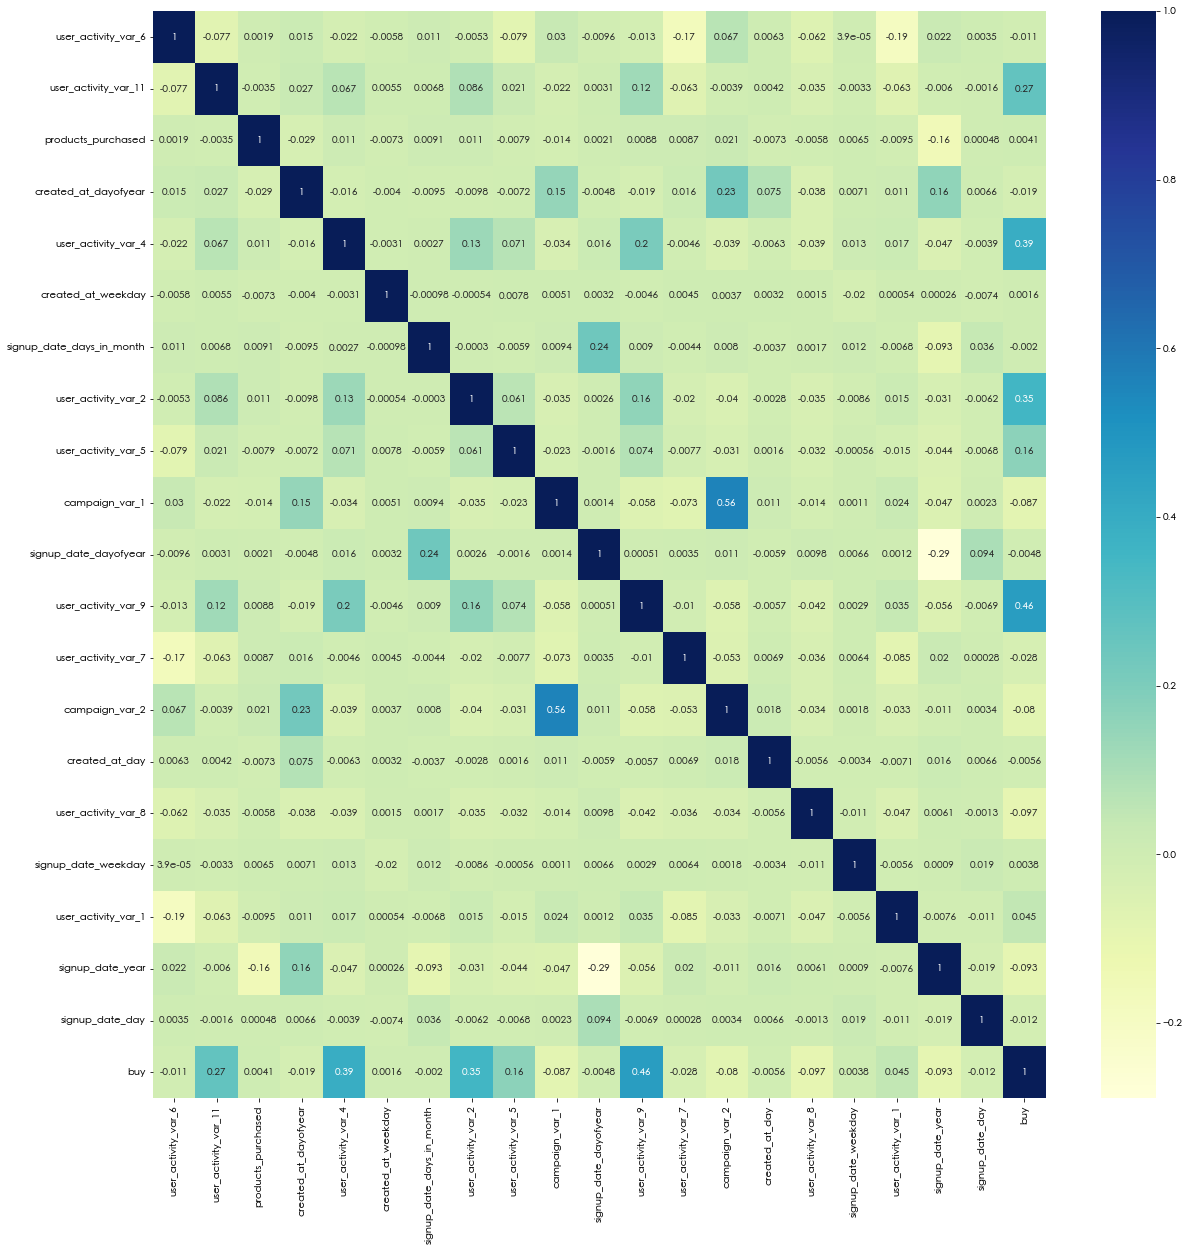

In [12]:
# Correlation plot
%matplotlib inline
plt.figure(figsize=(20,20))
sns.heatmap(Xy.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [13]:
tmp = Xy.corr()['buy'].reset_index()
tmp.loc[(tmp['buy']>=0.02) | (tmp['buy']<=-0.02), 'index'].unique()

array(['user_activity_var_11', 'user_activity_var_4',
       'user_activity_var_2', 'user_activity_var_5', 'campaign_var_1',
       'user_activity_var_9', 'user_activity_var_7', 'campaign_var_2',
       'user_activity_var_8', 'user_activity_var_1', 'signup_date_year',
       'buy'], dtype=object)

In [14]:

# Xy = Xy.set_index(idx_cols)

# Train-Val-Test split
# Xy_train = Xy[(Xy.index.get_level_values('created_at') <= datetime(2021,9,30))]
# Xy_val = Xy[(Xy.index.get_level_values('created_at') > datetime(2021,9,30)) & (Xy.index.get_level_values('created_at') <= datetime(2021,10,31))]
# Xy_test = Xy[(Xy.index.get_level_values('created_at') > datetime(2021,10,31))]


# Xy_train = Xy.loc[train_catboost.loc[(train_catboost['created_at'] <= '2021-09-30'), 'id'].unique()]
# Xy_val = Xy.loc[train_catboost.loc[(train_catboost['created_at'] > '2021-09-30') & (train_catboost['created_at'] <= '2021-10-31'), 'id'].unique()]
# Xy_test = Xy.loc[train_catboost.loc[(train_catboost['created_at'] > '2021-10-31'), 'id'].unique()]


# X_train = Xy_train[features]
# y_train = Xy_train[target]
# X_val = Xy_val[features]
# y_val = Xy_val[target]
# X_test = Xy_test[features]
# y_test = Xy_test[target]


# Random Sampling
X = Xy[features]
y = Xy[target]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(21929, 20) (21929,) (9399, 20) (9399,) (7833, 20) (7833,)


In [15]:
# ---------------------
# Train-Val-Test Pools
# ---------------------

from catboost import Pool

# initialize Pool
train_pool = Pool(
  X_train,
  y_train,
  cat_features=feature_target_mapping['cat_features']
)
val_pool = Pool(
  X_val,
  y_val,
  cat_features=feature_target_mapping['cat_features']
)
test_pool = Pool(
  X_test, 
  cat_features=feature_target_mapping['cat_features']
)

# Submission Pool
test_catboost_pool = Pool(
  test_catboost.reindex(features, axis=1),
  cat_features=feature_target_mapping['cat_features']
)


In [18]:
# Cross Validation

grid = {'learning_rate': [0.1, 0.5],
        'max_depth': [3, 4],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        # 'eval_metric': 'F1',
        'early_stopping_rounds': [100],
        # 'cat_features': feature_target_mapping['cat_features']
       }

grid_cb_model = CatBoostClassifier()

grid_search_result = grid_cb_model.grid_search(
    param_grid=grid,
    X=train_pool,
    # y=y_train,
    plot=True,
    verbose=False
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5500582	test: 0.5516321	best: 0.5516321 (0)	total: 18.3ms	remaining: 18.2s
1:	learn: 0.4464627	test: 0.4487288	best: 0.4487288 (1)	total: 33.5ms	remaining: 16.7s
2:	learn: 0.3592059	test: 0.3636746	best: 0.3636746 (2)	total: 42.7ms	remaining: 14.2s
3:	learn: 0.2975138	test: 0.3037009	best: 0.3037009 (3)	total: 50.8ms	remaining: 12.6s
4:	learn: 0.2529964	test: 0.2606529	best: 0.2606529 (4)	total: 61.6ms	remaining: 12.3s
5:	learn: 0.2225846	test: 0.2311871	best: 0.2311871 (5)	total: 69.8ms	remaining: 11.6s
6:	learn: 0.1957369	test: 0.2044296	best: 0.2044296 (6)	total: 80.4ms	remaining: 11.4s
7:	learn: 0.1755433	test: 0.1854685	best: 0.1854685 (7)	total: 88.2ms	remaining: 10.9s
8:	learn: 0.1547773	test: 0.1647080	best: 0.1647080 (8)	total: 94.3ms	remaining: 10.4s
9:	learn: 0.1442511	test: 0.1548938	best: 0.1548938 (9)	total: 97.4ms	remaining: 9.64s
10:	learn: 0.1358696	test: 0.1472216	best: 0.1472216 (10)	total: 106ms	remaining: 9.52s
11:	learn: 0.1265412	test: 0.1381001	best:

In [19]:
print(grid_search_result.get("params"))

{'depth': 4, 'od_wait': 100, 'l2_leaf_reg': 9, 'learning_rate': 0.1}


In [20]:

from catboost import Pool, cv
cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

params = {"iterations": 1000,
          "max_depth": 4,
          "l2_leaf_reg": 9,
          "loss_function": "Logloss",
          "learning_rate": 0.1,
          "early_stopping_rounds": 100,
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=5,
            plot="True"
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.09050770959
bestIteration = 205

Training on fold [1/5]

bestTest = 0.07823025806
bestIteration = 364

Training on fold [2/5]

bestTest = 0.08694578442
bestIteration = 236

Training on fold [3/5]

bestTest = 0.07344114439
bestIteration = 403

Training on fold [4/5]

bestTest = 0.08971980541
bestIteration = 202



In [21]:
version = 0.4
iterations = 10000
max_depth = 4
learning_rate = 0.1
eval_metric = 'F1'
early_stopping_rounds = 1000
l2_leaf_reg = 9

# ---------------------
# Classification
# ---------------------

from catboost import CatBoostClassifier #, cv

model = CatBoostClassifier(
    iterations=iterations,
    max_depth=max_depth,
    learning_rate=learning_rate,
    eval_metric=eval_metric,
    verbose=False,
    early_stopping_rounds=early_stopping_rounds,
    l2_leaf_reg = l2_leaf_reg
)

# train the model
model.fit(train_pool, eval_set=val_pool, plot=True) # 


# make the prediction using the resulting model
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
print("class = ", preds_class)
print("proba = ", preds_proba)

feature_imp_df = pd.DataFrame.from_dict(dict(zip(model.feature_names_, model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

class =  [0 0 0 ... 0 0 0]
proba =  [[9.99478150e-01 5.21850358e-04]
 [9.98866737e-01 1.13326310e-03]
 [9.99866172e-01 1.33828257e-04]
 ...
 [9.99969004e-01 3.09960279e-05]
 [9.99914205e-01 8.57952162e-05]
 [9.99317417e-01 6.82582617e-04]]


,feature,importance
6,signup_date_days_in_month,11.887106
13,campaign_var_2,8.151837
1,user_activity_var_11,7.400575
3,created_at_dayofyear,7.181854
16,signup_date_weekday,6.728377
15,user_activity_var_8,6.557695
18,signup_date_year,6.404246
10,signup_date_dayofyear,6.142675
14,created_at_day,5.950943
9,campaign_var_1,5.907732


In [22]:
feature_imp_df.loc[(feature_imp_df['importance'] < 1), 'feature'].unique()

array([], dtype=object)

In [23]:
# # Check feature importances
# feature_imp_df = pd.DataFrame.from_dict(
#     dict(
#         zip(
#             model.feature_names_, model.feature_importances_
#         )
#     ),
#     orient='index', 
#     columns=['importance']
# ).reset_index(
# ).rename(
#     columns={
#         'index': 'feature'
#     }
# ).sort_values('importance', ascending=False)
# feature_imp_df


In [24]:
# ------------------------
# Classification
# ------------------------

def plot_confusion_matrix(y_test, y_pred):

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()


# plot_confusion_matrix(y_test, y_pred=preds_class)

Accuracy of the classifier is: 0.9754883186518575
Precision Score of the classifier is: 0.8981132075471698
Recall Score of the classifier is: 0.5905707196029777
F1 Score of the classifier is: 0.7125748502994012
True Positive : 7403
False Positive : 27
False Negative : 165
True Negative : 238


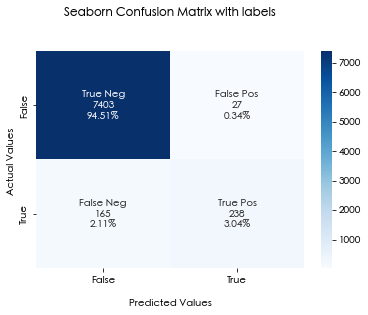

In [25]:
def get_classification_eval_metrics(y_test, y_pred):

    from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score#, plot_confusion_matrix
    import matplotlib.pyplot as plt

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the classifier is: {accuracy}")
    precision = precision_score(y_test, y_pred)
    print(f"Precision Score of the classifier is: {precision}")
    recall = recall_score(y_test, y_pred)
    print(f"Recall Score of the classifier is: {recall}")
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score of the classifier is: {f1}")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"True Positive : {conf_matrix[0][0]}\nFalse Positive : {conf_matrix[0][1]}\nFalse Negative : {conf_matrix[1][0]}\nTrue Negative : {conf_matrix[1][1]}")
    plot_confusion_matrix(y_test, y_pred)
    plt.show()
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_classification_eval_metrics(y_test, y_pred=preds_class)

AUC for our classifier is: 0.9500632871231579


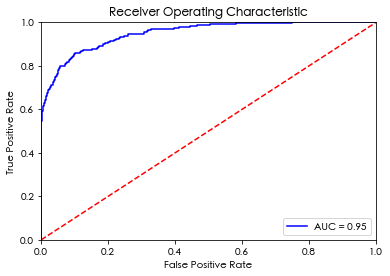

In [26]:
def get_roc_auc_curve(model, X_test, y_test):

    # Importing all necessary libraries
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    class_probabilities = model.predict_proba(X_test)
    preds = class_probabilities[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # Printing AUC
    print(f"AUC for our classifier is: {roc_auc}")

    # Plotting the ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

get_roc_auc_curve(model, X_test, y_test)


Threshold: 0.4
Accuracy of the classifier is: 0.9745946636027065
Precision Score of the classifier is: 0.8642857142857143
Recall Score of the classifier is: 0.6004962779156328
F1 Score of the classifier is: 0.7086383601756954
True Positive : 7392
False Positive : 38
False Negative : 161
True Negative : 242


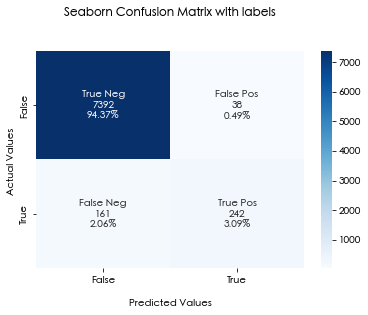


Threshold: 0.45
Accuracy of the classifier is: 0.9751053236307928
Precision Score of the classifier is: 0.8823529411764706
Recall Score of the classifier is: 0.5955334987593052
F1 Score of the classifier is: 0.7111111111111111
True Positive : 7398
False Positive : 32
False Negative : 163
True Negative : 240


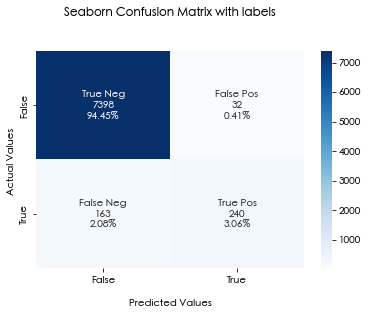


Threshold: 0.5
Accuracy of the classifier is: 0.9754883186518575
Precision Score of the classifier is: 0.8981132075471698
Recall Score of the classifier is: 0.5905707196029777
F1 Score of the classifier is: 0.7125748502994012
True Positive : 7403
False Positive : 27
False Negative : 165
True Negative : 238


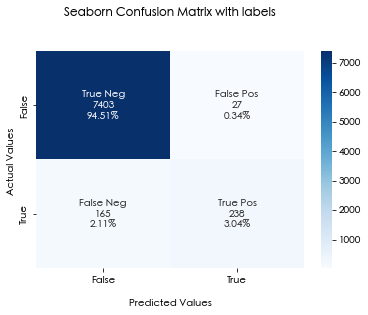


Threshold: 0.55
Accuracy of the classifier is: 0.9756159836588791
Precision Score of the classifier is: 0.9015151515151515
Recall Score of the classifier is: 0.5905707196029777
F1 Score of the classifier is: 0.7136431784107946
True Positive : 7404
False Positive : 26
False Negative : 165
True Negative : 238


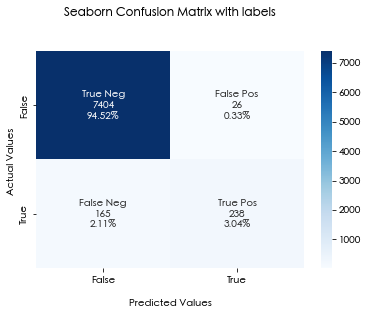


Threshold: 0.6
Accuracy of the classifier is: 0.9763819737010085
Precision Score of the classifier is: 0.92578125
Recall Score of the classifier is: 0.5880893300248139
F1 Score of the classifier is: 0.7192716236722307
True Positive : 7411
False Positive : 19
False Negative : 166
True Negative : 237


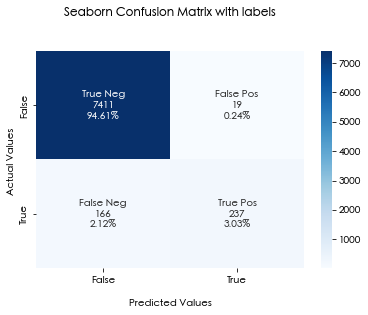


Threshold: 0.61
Accuracy of the classifier is: 0.9766373037150518
Precision Score of the classifier is: 0.9365079365079365
Recall Score of the classifier is: 0.5856079404466501
F1 Score of the classifier is: 0.7206106870229008
True Positive : 7414
False Positive : 16
False Negative : 167
True Negative : 236


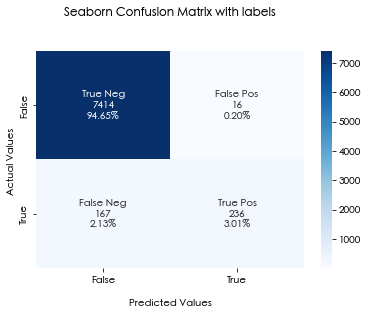


Threshold: 0.62
Accuracy of the classifier is: 0.9767649687220733
Precision Score of the classifier is: 0.9402390438247012
Recall Score of the classifier is: 0.5856079404466501
F1 Score of the classifier is: 0.7217125382262997
True Positive : 7415
False Positive : 15
False Negative : 167
True Negative : 236


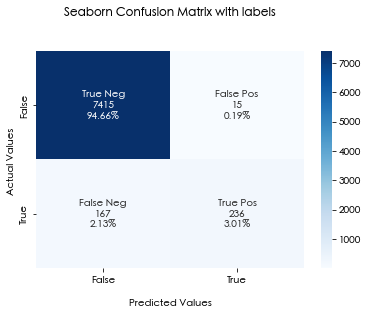


Threshold: 0.63
Accuracy of the classifier is: 0.9766373037150518
Precision Score of the classifier is: 0.9435483870967742
Recall Score of the classifier is: 0.5806451612903226
F1 Score of the classifier is: 0.7188940092165899
True Positive : 7416
False Positive : 14
False Negative : 169
True Negative : 234


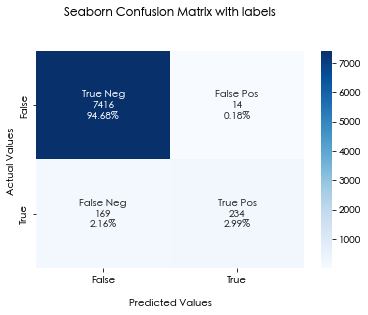


Threshold: 0.64
Accuracy of the classifier is: 0.9766373037150518
Precision Score of the classifier is: 0.9435483870967742
Recall Score of the classifier is: 0.5806451612903226
F1 Score of the classifier is: 0.7188940092165899
True Positive : 7416
False Positive : 14
False Negative : 169
True Negative : 234


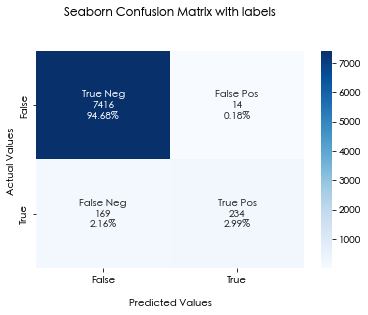


Threshold: 0.65
Accuracy of the classifier is: 0.9767649687220733
Precision Score of the classifier is: 0.9510204081632653
Recall Score of the classifier is: 0.5781637717121588
F1 Score of the classifier is: 0.7191358024691358
True Positive : 7418
False Positive : 12
False Negative : 170
True Negative : 233


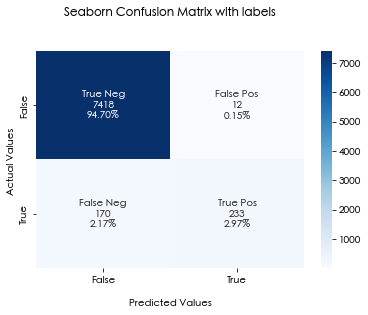


Threshold: 0.7
Accuracy of the classifier is: 0.9759989786799438
Precision Score of the classifier is: 0.9535864978902954
Recall Score of the classifier is: 0.5607940446650124
F1 Score of the classifier is: 0.7062499999999999
True Positive : 7419
False Positive : 11
False Negative : 177
True Negative : 226


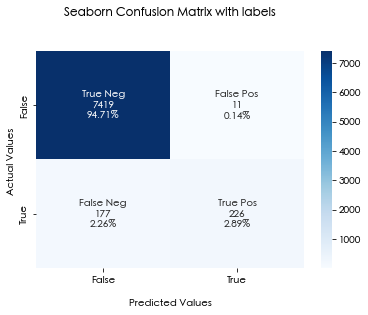

In [29]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7]

def threshold_evaluations(model, df, thresholds=[0.5, 0.4, 0.6]):

    df['proba'] = model.predict_proba(df.reindex(model.feature_names_, axis=1))[:,1]
    # print(df['proba'].value_counts())

    for threshold in thresholds:

        print(f'\nThreshold: {threshold}')
        df.loc[(df['proba'] >= threshold), f'y_pred_{threshold}'] = 1
        # print(df[['proba', f'y_pred_{threshold}']])
        # print(df[f'y_pred_{threshold}'].value_counts())
        df[f'y_pred_{threshold}'] = df[f'y_pred_{threshold}'].fillna(0)
        # print(df[f'y_pred_{threshold}'].value_counts())
        get_classification_eval_metrics(y_test, y_pred=df[f'y_pred_{threshold}'])

threshold_evaluations(model, X_test, thresholds=thresholds)

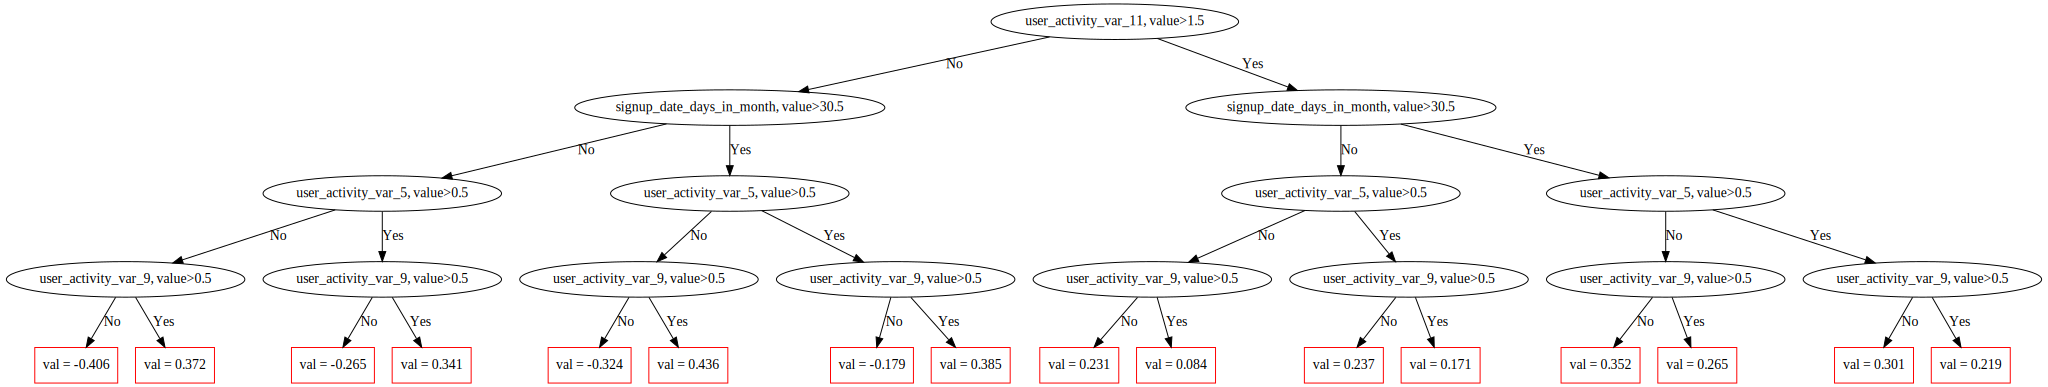

In [30]:
# Plot the tree to understand the split
model.plot_tree(0, pool=train_pool)

In [31]:
# Check visualisation of test and pred set to understand the predictions accuracy.
pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': preds_class})
dtale.show(pred_df)

In [32]:
# Save file for submission

test_catboost['proba'] = model.predict_proba(test_catboost_pool)[:, 1]
test_catboost.loc[(test_catboost['proba'] >= 0.62), 'buy'] = 1
test_catboost['buy'] = test_catboost['buy'].fillna(0)
test_catboost['buy'] = test_catboost['buy'].astype(int)

test_catboost

,,,user_activity_var_6,user_activity_var_11,products_purchased,created_at_dayofyear,user_activity_var_4,created_at_weekday,signup_date_days_in_month,user_activity_var_2,user_activity_var_5,campaign_var_1,...,user_activity_var_7,campaign_var_2,created_at_day,user_activity_var_8,signup_date_weekday,user_activity_var_1,signup_date_year,signup_date_day,buy,proba
id,created_at,signup_date,,,,,,,,,,,,,,,,,,,,,
39162,2022-01-01,2021-08-17,1.0,1.0,NaN,1.0,0.0,5.0,31.0,1.0,0.0,2.0,...,0.0,2.0,1.0,0.0,1.0,1.0,2021.0,17.0,1,0.633919
39163,2022-01-01,2020-05-21,0.0,0.0,3.0,1.0,0.0,5.0,31.0,0.0,0.0,4.0,...,0.0,7.0,1.0,1.0,3.0,1.0,2020.0,21.0,0,0.000938
39164,2022-01-01,NaT,1.0,0.0,NaN,1.0,0.0,5.0,NaN,0.0,1.0,8.0,...,0.0,7.0,1.0,0.0,NaN,0.0,NaN,NaN,0,0.011410
39165,2022-01-01,2020-06-22,1.0,2.0,2.0,1.0,0.0,5.0,30.0,0.0,1.0,9.0,...,1.0,8.0,1.0,0.0,0.0,0.0,2020.0,22.0,1,0.981313
39166,2022-01-01,2021-03-10,0.0,0.0,2.0,1.0,0.0,5.0,31.0,0.0,0.0,4.0,...,0.0,5.0,1.0,0.0,2.0,1.0,2021.0,10.0,0,0.002367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52341,2022-03-30,NaT,1.0,0.0,NaN,89.0,0.0,2.0,NaN,0.0,0.0,16.0,...,1.0,12.0,30.0,0.0,NaN,0.0,NaN,NaN,0,0.000014
52342,2022-03-30,2022-03-19,1.0,0.0,NaN,89.0,0.0,2.0,31.0,0.0,0.0,12.0,...,0.0,8.0,30.0,0.0,5.0,1.0,2022.0,19.0,0,0.008789
52343,2022-03-30,2021-08-15,0.0,0.0,3.0,89.0,0.0,2.0,31.0,0.0,0.0,14.0,...,1.0,14.0,30.0,0.0,6.0,0.0,2021.0,15.0,0,0.000157


In [34]:
submission = test_catboost.reset_index()[['id', 'buy']]#.set_index('id')

file_name = f"v{version}_cb_{eval_metric}_{max_depth}_{learning_rate}-{accuracy}_{precision}_{recall}_{f1}.csv"
print(file_name)
submission.to_csv(f'{DATA_DIR}/{file_name}', index=False) # _{l2}
submission

v0.4_cb_F1_4_0.1-0.9754883186518575_0.8981132075471698_0.5905707196029777_0.7125748502994012.csv


,id,buy
0,39162,1
1,39163,0
2,39164,0
3,39165,1
4,39166,0
...,...,...
13179,52341,0
13180,52342,0
13181,52343,0
13182,52344,0


### XGBoost

In [35]:
X_train.sample()

,,,user_activity_var_6,user_activity_var_11,products_purchased,created_at_dayofyear,user_activity_var_4,created_at_weekday,signup_date_days_in_month,user_activity_var_2,user_activity_var_5,campaign_var_1,signup_date_dayofyear,user_activity_var_9,user_activity_var_7,campaign_var_2,created_at_day,user_activity_var_8,signup_date_weekday,user_activity_var_1,signup_date_year,signup_date_day
id,created_at,signup_date,,,,,,,,,,,,,,,,,,,,
12342,2021-06-24,NaT,1.0,0.0,NaN,175.0,0.0,3.0,NaN,0.0,0.0,5.0,NaN,0.0,0.0,4.0,24.0,1.0,NaN,1.0,NaN,NaN


In [36]:
y_train.sample()

id    created_at  signup_date
1650  2021-02-09  2022-03-19     0
Name: buy, dtype: int64

In [37]:
X_train.shape

(21929, 20)

In [38]:
X_test.shape

(7833, 32)

In [39]:
import xgboost as xgb

version=0.5
n_estimators=10000
max_depth=4
learning_rate=0.1
random_state=42
early_stopping_rounds=100
eval_metric='error'

xgb_model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    random_state=random_state,
    early_stopping_rounds=early_stopping_rounds, 
    min_child_weight=6,
    gamma=0.3,
    subsample=0.85,
    colsample_bytree=0.75
    # eval_metric="F1"
)

# After grid search tuning
# xgb_model = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=6, gamma=0.3, subsample=0.85, colsample_bytree=0.75, reg_alpha=100,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

xgb_model.fit(X=X_train, y=y_train, eval_metric=eval_metric, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-error:0.04139
[1]	validation_0-error:0.03277
[2]	validation_0-error:0.03107
[3]	validation_0-error:0.03096
[4]	validation_0-error:0.02905
[5]	validation_0-error:0.02702
[6]	validation_0-error:0.02745


/Users/saurabhnair/Documents/personal/projects/py/venv/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[7]	validation_0-error:0.02702
[8]	validation_0-error:0.02692
[9]	validation_0-error:0.02692
[10]	validation_0-error:0.02692
[11]	validation_0-error:0.02692
[12]	validation_0-error:0.02692
[13]	validation_0-error:0.02702
[14]	validation_0-error:0.02692
[15]	validation_0-error:0.02692
[16]	validation_0-error:0.02692
[17]	validation_0-error:0.02724
[18]	validation_0-error:0.02702
[19]	validation_0-error:0.02702
[20]	validation_0-error:0.02713
[21]	validation_0-error:0.02713
[22]	validation_0-error:0.02724
[23]	validation_0-error:0.02724
[24]	validation_0-error:0.02745
[25]	validation_0-error:0.02734
[26]	validation_0-error:0.02745
[27]	validation_0-error:0.02734
[28]	validation_0-error:0.02734
[29]	validation_0-error:0.02734
[30]	validation_0-error:0.02734
[31]	validation_0-error:0.02734
[32]	validation_0-error:0.02734
[33]	validation_0-error:0.02734
[34]	validation_0-error:0.02734
[35]	validation_0-error:0.02734
[36]	validation_0-error:0.02724
[37]	validation_0-error:0.02724
[38]	valida

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=10000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [40]:

# make the prediction using the resulting model
preds_class = xgb_model.predict(X_test.reindex(X_train.columns, axis=1))
preds_proba = xgb_model.predict_proba(X_test.reindex(X_train.columns, axis=1))
print("class = ", preds_class)
print("proba = ", preds_proba)

feature_imp_df = pd.DataFrame.from_dict(dict(zip(xgb_model.feature_names_in_, model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


class =  [0 0 0 ... 0 0 0]
proba =  [[9.9730402e-01 2.6959660e-03]
 [9.9438298e-01 5.6170421e-03]
 [9.9888510e-01 1.1148783e-03]
 ...
 [9.9958676e-01 4.1322844e-04]
 [9.9900752e-01 9.9245517e-04]
 [9.9799800e-01 2.0020038e-03]]


,feature,importance
6,signup_date_days_in_month,11.887106
13,campaign_var_2,8.151837
1,user_activity_var_11,7.400575
3,created_at_dayofyear,7.181854
16,signup_date_weekday,6.728377
15,user_activity_var_8,6.557695
18,signup_date_year,6.404246
10,signup_date_dayofyear,6.142675
14,created_at_day,5.950943
9,campaign_var_1,5.907732


Accuracy of the classifier is: 0.9758713136729222
Precision Score of the classifier is: 0.9246031746031746
Recall Score of the classifier is: 0.5781637717121588
F1 Score of the classifier is: 0.7114503816793893
True Positive : 7411
False Positive : 19
False Negative : 170
True Negative : 233


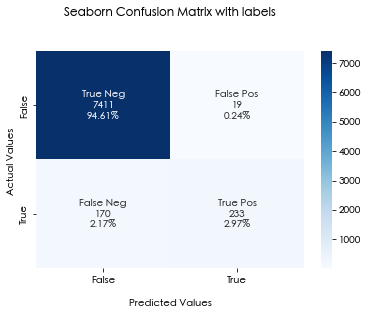

In [42]:
accuracy, precision, recall, f1 = get_classification_eval_metrics(y_test, y_pred=preds_class)

AUC for our classifier is: 0.9500632871231579


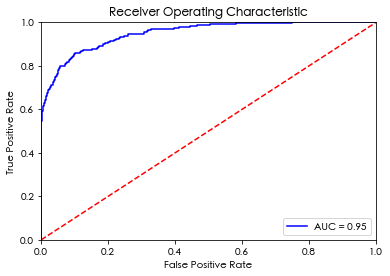

In [43]:
get_roc_auc_curve(model, X_test, y_test)


Threshold: 0.4
Accuracy of the classifier is: 0.9749776586237712
Precision Score of the classifier is: 0.8532423208191127
Recall Score of the classifier is: 0.6203473945409429
F1 Score of the classifier is: 0.7183908045977011
True Positive : 7387
False Positive : 43
False Negative : 153
True Negative : 250


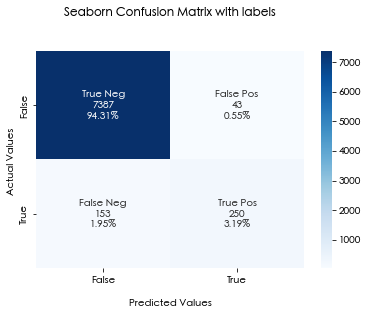


Threshold: 0.45
Accuracy of the classifier is: 0.9752329886378144
Precision Score of the classifier is: 0.8692579505300353
Recall Score of the classifier is: 0.6104218362282878
F1 Score of the classifier is: 0.717201166180758
True Positive : 7393
False Positive : 37
False Negative : 157
True Negative : 246


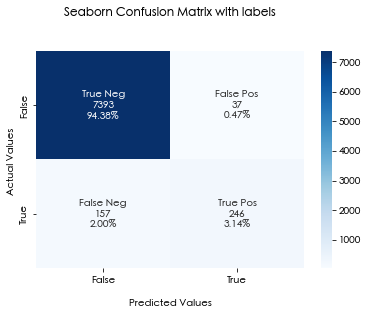


Threshold: 0.5
Accuracy of the classifier is: 0.9752329886378144
Precision Score of the classifier is: 0.8827838827838828
Recall Score of the classifier is: 0.598014888337469
F1 Score of the classifier is: 0.7130177514792899
True Positive : 7398
False Positive : 32
False Negative : 162
True Negative : 241


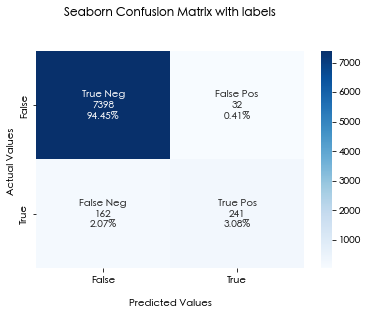


Threshold: 0.55
Accuracy of the classifier is: 0.9754883186518575
Precision Score of the classifier is: 0.8951310861423221
Recall Score of the classifier is: 0.5930521091811415
F1 Score of the classifier is: 0.7134328358208957
True Positive : 7402
False Positive : 28
False Negative : 164
True Negative : 239


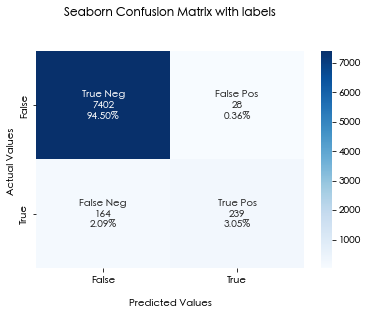


Threshold: 0.57
Accuracy of the classifier is: 0.9763819737010085
Precision Score of the classifier is: 0.957983193277311
Recall Score of the classifier is: 0.56575682382134
F1 Score of the classifier is: 0.7113884555382215
True Positive : 7420
False Positive : 10
False Negative : 175
True Negative : 228


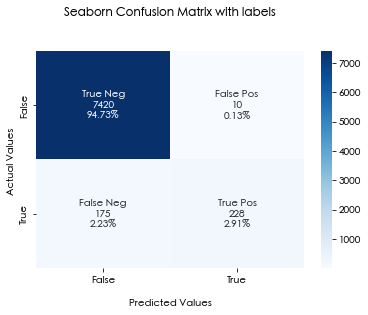


Threshold: 0.6
Accuracy of the classifier is: 0.976254308693987
Precision Score of the classifier is: 0.9221789883268483
Recall Score of the classifier is: 0.5880893300248139
F1 Score of the classifier is: 0.7181818181818181
True Positive : 7410
False Positive : 20
False Negative : 166
True Negative : 237


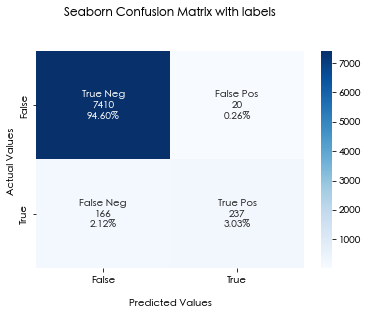


Threshold: 0.62
Accuracy of the classifier is: 0.9766373037150518
Precision Score of the classifier is: 0.9365079365079365
Recall Score of the classifier is: 0.5856079404466501
F1 Score of the classifier is: 0.7206106870229008
True Positive : 7414
False Positive : 16
False Negative : 167
True Negative : 236


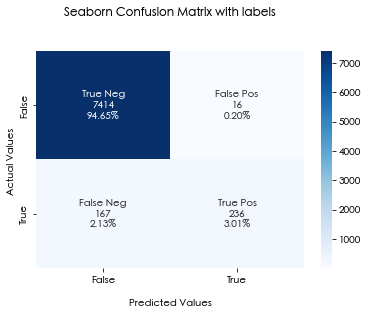


Threshold: 0.65
Accuracy of the classifier is: 0.9766373037150518
Precision Score of the classifier is: 0.9471544715447154
Recall Score of the classifier is: 0.5781637717121588
F1 Score of the classifier is: 0.7180277349768877
True Positive : 7417
False Positive : 13
False Negative : 170
True Negative : 233


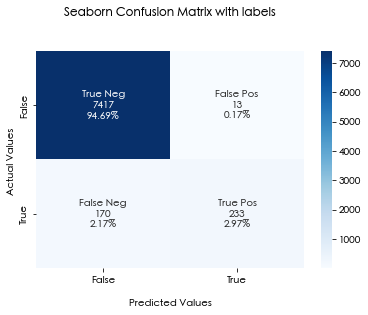


Threshold: 0.7
Accuracy of the classifier is: 0.9759989786799438
Precision Score of the classifier is: 0.9497907949790795
Recall Score of the classifier is: 0.5632754342431762
F1 Score of the classifier is: 0.707165109034268
True Positive : 7418
False Positive : 12
False Negative : 176
True Negative : 227


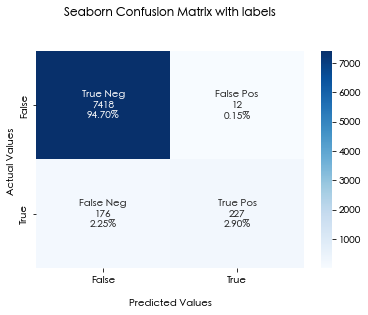

In [46]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.57, 0.6, 0.62, 0.65, 0.7]

def threshold_evaluations(model, df, thresholds=[0.5, 0.4, 0.6]):

    df['proba'] = model.predict_proba(df.reindex(model.feature_names_in_, axis=1))[:,1]
    # print(df['proba'].value_counts())

    for threshold in thresholds:

        print(f'\nThreshold: {threshold}')
        df.loc[(df['proba'] >= threshold), f'y_pred_{threshold}'] = 1
        # print(df[['proba', f'y_pred_{threshold}']])
        # print(df[f'y_pred_{threshold}'].value_counts())
        df[f'y_pred_{threshold}'] = df[f'y_pred_{threshold}'].fillna(0)
        # print(df[f'y_pred_{threshold}'].value_counts())
        get_classification_eval_metrics(y_test, y_pred=df[f'y_pred_{threshold}'])

threshold_evaluations(xgb_model, X_test, thresholds=thresholds)

In [47]:
# Save file for submission

test_catboost['proba_xgb'] = xgb_model.predict_proba(test_catboost.reindex(X_train.columns,axis=1))[:, 1]
test_catboost.loc[(test_catboost['proba_xgb'] >= 0.62), 'buy_xgb'] = 1
test_catboost['buy_xgb'] = test_catboost['buy_xgb'].fillna(0)
test_catboost['buy_xgb'] = test_catboost['buy_xgb'].astype(int)

test_catboost

,,,user_activity_var_6,user_activity_var_11,products_purchased,created_at_dayofyear,user_activity_var_4,created_at_weekday,signup_date_days_in_month,user_activity_var_2,user_activity_var_5,campaign_var_1,...,created_at_day,user_activity_var_8,signup_date_weekday,user_activity_var_1,signup_date_year,signup_date_day,buy,proba,proba_xgb,buy_xgb
id,created_at,signup_date,,,,,,,,,,,,,,,,,,,,,
39162,2022-01-01,2021-08-17,1.0,1.0,NaN,1.0,0.0,5.0,31.0,1.0,0.0,2.0,...,1.0,0.0,1.0,1.0,2021.0,17.0,1,0.633919,0.903727,1
39163,2022-01-01,2020-05-21,0.0,0.0,3.0,1.0,0.0,5.0,31.0,0.0,0.0,4.0,...,1.0,1.0,3.0,1.0,2020.0,21.0,0,0.000938,0.004723,0
39164,2022-01-01,NaT,1.0,0.0,NaN,1.0,0.0,5.0,NaN,0.0,1.0,8.0,...,1.0,0.0,NaN,0.0,NaN,NaN,0,0.011410,0.004019,0
39165,2022-01-01,2020-06-22,1.0,2.0,2.0,1.0,0.0,5.0,30.0,0.0,1.0,9.0,...,1.0,0.0,0.0,0.0,2020.0,22.0,1,0.981313,0.905660,1
39166,2022-01-01,2021-03-10,0.0,0.0,2.0,1.0,0.0,5.0,31.0,0.0,0.0,4.0,...,1.0,0.0,2.0,1.0,2021.0,10.0,0,0.002367,0.017624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52341,2022-03-30,NaT,1.0,0.0,NaN,89.0,0.0,2.0,NaN,0.0,0.0,16.0,...,30.0,0.0,NaN,0.0,NaN,NaN,0,0.000014,0.000618,0
52342,2022-03-30,2022-03-19,1.0,0.0,NaN,89.0,0.0,2.0,31.0,0.0,0.0,12.0,...,30.0,0.0,5.0,1.0,2022.0,19.0,0,0.008789,0.011278,0
52343,2022-03-30,2021-08-15,0.0,0.0,3.0,89.0,0.0,2.0,31.0,0.0,0.0,14.0,...,30.0,0.0,6.0,0.0,2021.0,15.0,0,0.000157,0.004428,0


In [48]:
submission = test_catboost.reset_index()[['id', 'buy_xgb']].rename(columns={'buy_xgb': 'buy'})

file_name = f"v{version}_xgb_{eval_metric}_{max_depth}_{learning_rate}-{accuracy}_{precision}_{recall}_{f1}.csv"
print(file_name)
submission.to_csv(f'{DATA_DIR}/{file_name}', index=False) # _{l2}
submission

v0.5_xgb_error_4_0.1-0.9758713136729222_0.9246031746031746_0.5781637717121588_0.7114503816793893.csv


,id,buy
0,39162,1
1,39163,0
2,39164,0
3,39165,1
4,39166,0
...,...,...
13179,52341,0
13180,52342,0
13181,52343,0
13182,52344,0


### Grid Search

In [49]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(X, y)

gsearch1.best_score_, gsearch1.best_params_, gsearch1.best_score_

(0.941310491496013, {'max_depth': 3, 'min_child_weight': 5}, 0.941310491496013)

In [50]:
max_depth = gsearch1.best_params_['max_depth']
min_child_weight = gsearch1.best_params_['min_child_weight']

In [51]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(X, y)
gsearch2.best_score_, gsearch2.best_params_, gsearch2.best_score_


(0.9296032662530533,
 {'max_depth': 4, 'min_child_weight': 6},
 0.9296032662530533)

In [52]:
max_depth = gsearch2.best_params_['max_depth']
min_child_weight = gsearch2.best_params_['min_child_weight']

In [53]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2b.fit(X, y)

# modelfit(gsearch3.best_estimator_, train, predictors)
gsearch2b.best_score_, gsearch2b.best_params_, gsearch2b.best_score_

(0.9360374933229311, {'min_child_weight': 12}, 0.9360374933229311)

In [54]:
min_child_weight = gsearch2b.best_params_['min_child_weight']

In [55]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)

gsearch3.fit(X, y)
gsearch3.best_score_, gsearch3.best_params_, gsearch3.best_score_

(0.9364282141748319, {'gamma': 0.1}, 0.9364282141748319)

In [56]:
gamma = gsearch3.best_params_['gamma']

In [57]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)

gsearch4.fit(X, y)
gsearch4.best_score_, gsearch4.best_params_, gsearch4.best_score_

(0.9387438454533938,
 {'colsample_bytree': 0.7, 'subsample': 0.6},
 0.9387438454533938)

In [58]:
colsample_bytree = gsearch4.best_params_['colsample_bytree']
subsample = gsearch4.best_params_['subsample']

In [59]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)

gsearch5.fit(X, y)
gsearch5.best_score_, gsearch5.best_params_, gsearch5.best_score_

(0.9387558237877002,
 {'colsample_bytree': 0.85, 'subsample': 0.75},
 0.9387558237877002)

In [60]:
colsample_bytree = gsearch4.best_params_['colsample_bytree']
subsample = gsearch4.best_params_['subsample']

In [61]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)

gsearch6.fit(X, y)
gsearch6.best_score_, gsearch6.best_params_, gsearch6.best_score_

(0.9389656194813994, {'reg_alpha': 100}, 0.9389656194813994)

In [62]:
reg_alpha = gsearch6.best_params_['reg_alpha']

In [63]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)

gsearch7.fit(X, y)
gsearch7.best_score_, gsearch7.best_params_, gsearch7.best_score_

(0.9389656194813994, {'reg_alpha': 100}, 0.9389656194813994)

In [64]:
reg_alpha = gsearch7.best_params_['reg_alpha']

In [ ]:
xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [78]:
import xgboost as xgb

version=0.6
n_estimators=10000
# max_depth=4
learning_rate=0.1
# random_state=42
early_stopping_rounds=100
eval_metric='error'

xgb_model = xgb.XGBClassifier(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    early_stopping_rounds=early_stopping_rounds,
    min_child_weight=min_child_weight,
    # gamma=gamma,
    # subsample=subsample,
    # colsample_bytree=colsample_bytree,
    # reg_alpha=reg_alpha,
    objective='binary:logistic',
    nthread=4,
    # scale_pos_weight=1,
    seed=27
)

xgb_model.fit(X=X_train, y=y_train, eval_metric=eval_metric, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-error:0.02745
[1]	validation_0-error:0.02745
[2]	validation_0-error:0.02745
[3]	validation_0-error:0.02745
[4]	validation_0-error:0.02745
[5]	validation_0-error:0.02745
[6]	validation_0-error:0.02745
[7]	validation_0-error:0.02745
[8]	validation_0-error:0.02745
[9]	validation_0-error:0.02745
[10]	validation_0-error:0.02745
[11]	validation_0-error:0.02745
[12]	validation_0-error:0.02745
[13]	validation_0-error:0.02745
[14]	validation_0-error:0.02724
[15]	validation_0-error:0.02724
[16]	validation_0-error:0.02734
[17]	validation_0-error:0.02734
[18]	validation_0-error:0.02702
[19]	validation_0-error:0.02702
[20]	validation_0-error:0.02724
[21]	validation_0-error:0.02724
[22]	validation_0-error:0.02724
[23]	validation_0-error:0.02724
[24]	validation_0-error:0.02724
[25]	validation_0-error:0.02745
[26]	validation_0-error:0.02745
[27]	validation_0-error:0.02745
[28]	validation_0-error:0.02745
[29]	validation_0-error:0.02745
[30]	validation_0-error:0.02734
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=12,
              missing=nan, monotone_constraints='()', n_estimators=10000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [79]:

# make the prediction using the resulting model
preds_class = xgb_model.predict(X_test.reindex(X_train.columns, axis=1))
preds_proba = xgb_model.predict_proba(X_test.reindex(X_train.columns, axis=1))
print("class = ", preds_class)
print("proba = ", preds_proba)

feature_imp_df = pd.DataFrame.from_dict(dict(zip(xgb_model.feature_names_in_, model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


class =  [0 0 0 ... 0 0 0]
proba =  [[0.99524164 0.00475833]
 [0.9907449  0.00925514]
 [0.99855846 0.00144153]
 ...
 [0.9989326  0.00106739]
 [0.9978329  0.00216708]
 [0.99728507 0.00271493]]


,feature,importance
6,signup_date_days_in_month,11.887106
13,campaign_var_2,8.151837
1,user_activity_var_11,7.400575
3,created_at_dayofyear,7.181854
16,signup_date_weekday,6.728377
15,user_activity_var_8,6.557695
18,signup_date_year,6.404246
10,signup_date_dayofyear,6.142675
14,created_at_day,5.950943
9,campaign_var_1,5.907732


Accuracy of the classifier is: 0.9767649687220733
Precision Score of the classifier is: 0.9623430962343096
Recall Score of the classifier is: 0.5707196029776674
F1 Score of the classifier is: 0.7165109034267912
True Positive : 7421
False Positive : 9
False Negative : 173
True Negative : 230


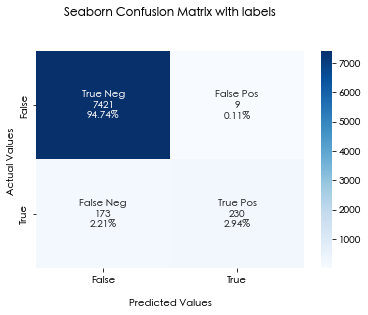

In [80]:
accuracy, precision, recall, f1 = get_classification_eval_metrics(y_test, y_pred=preds_class)

AUC for our classifier is: 0.9500632871231579


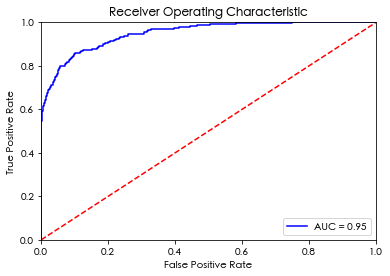

In [81]:
get_roc_auc_curve(model, X_test, y_test)


Threshold: 0.4
Accuracy of the classifier is: 0.9749776586237712
Precision Score of the classifier is: 0.8508474576271187
Recall Score of the classifier is: 0.6228287841191067
F1 Score of the classifier is: 0.7191977077363896
True Positive : 7386
False Positive : 44
False Negative : 152
True Negative : 251


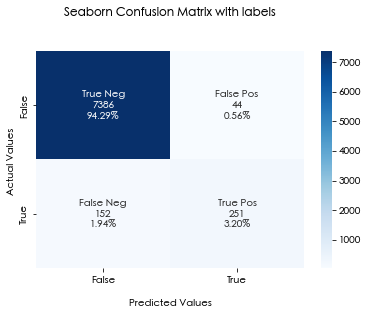


Threshold: 0.45
Accuracy of the classifier is: 0.9752329886378144
Precision Score of the classifier is: 0.8692579505300353
Recall Score of the classifier is: 0.6104218362282878
F1 Score of the classifier is: 0.717201166180758
True Positive : 7393
False Positive : 37
False Negative : 157
True Negative : 246


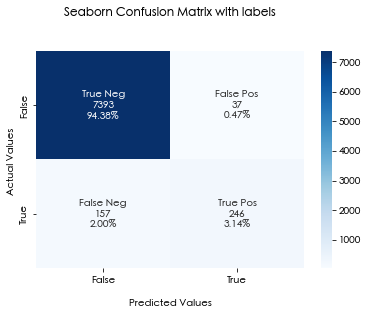


Threshold: 0.5
Accuracy of the classifier is: 0.9753606536448359
Precision Score of the classifier is: 0.8832116788321168
Recall Score of the classifier is: 0.6004962779156328
F1 Score of the classifier is: 0.7149187592319054
True Positive : 7398
False Positive : 32
False Negative : 161
True Negative : 242


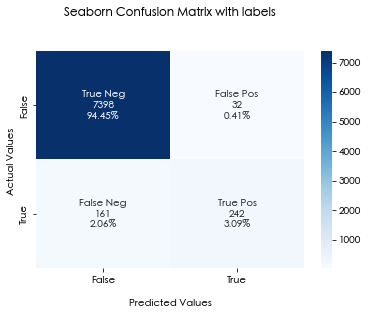


Threshold: 0.55
Accuracy of the classifier is: 0.9758713136729222
Precision Score of the classifier is: 0.8962962962962963
Recall Score of the classifier is: 0.6004962779156328
F1 Score of the classifier is: 0.7191679049034176
True Positive : 7402
False Positive : 28
False Negative : 161
True Negative : 242


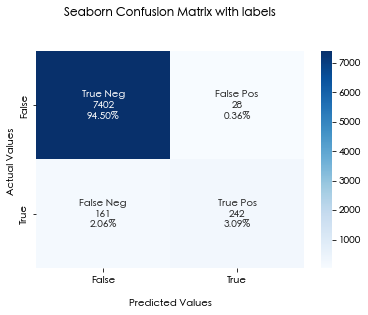


Threshold: 0.57
Accuracy of the classifier is: 0.9766373037150518
Precision Score of the classifier is: 0.9545454545454546
Recall Score of the classifier is: 0.5732009925558312
F1 Score of the classifier is: 0.7162790697674418
True Positive : 7419
False Positive : 11
False Negative : 172
True Negative : 231


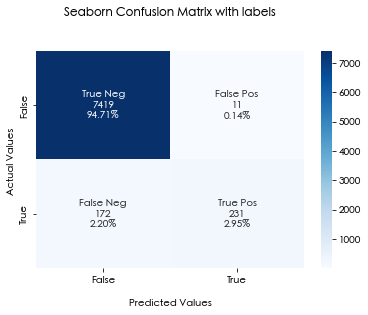


Threshold: 0.6
Accuracy of the classifier is: 0.9765096387080301
Precision Score of the classifier is: 0.9227799227799228
Recall Score of the classifier is: 0.5930521091811415
F1 Score of the classifier is: 0.7220543806646527
True Positive : 7410
False Positive : 20
False Negative : 164
True Negative : 239


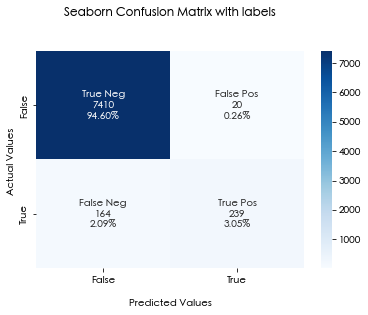


Threshold: 0.62
Accuracy of the classifier is: 0.9767649687220733
Precision Score of the classifier is: 0.9367588932806324
Recall Score of the classifier is: 0.5880893300248139
F1 Score of the classifier is: 0.7225609756097562
True Positive : 7414
False Positive : 16
False Negative : 166
True Negative : 237


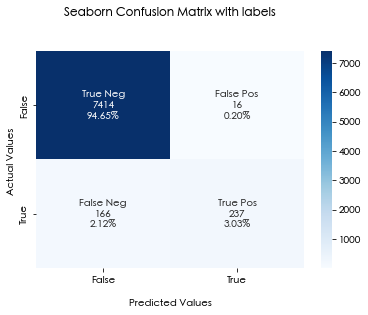


Threshold: 0.65
Accuracy of the classifier is: 0.9767649687220733
Precision Score of the classifier is: 0.9473684210526315
Recall Score of the classifier is: 0.5806451612903226
F1 Score of the classifier is: 0.72
True Positive : 7417
False Positive : 13
False Negative : 169
True Negative : 234


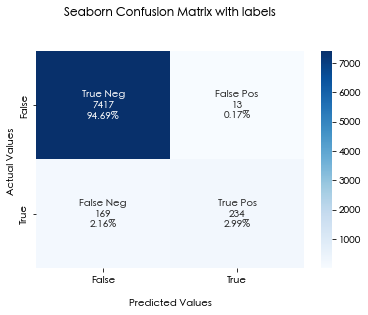


Threshold: 0.7
Accuracy of the classifier is: 0.9759989786799438
Precision Score of the classifier is: 0.9497907949790795
Recall Score of the classifier is: 0.5632754342431762
F1 Score of the classifier is: 0.707165109034268
True Positive : 7418
False Positive : 12
False Negative : 176
True Negative : 227


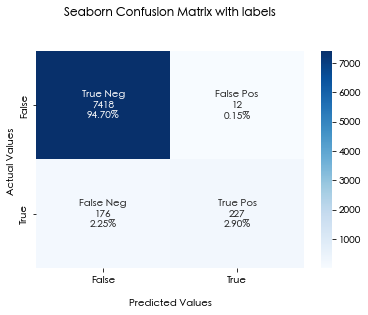

In [82]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.57, 0.6, 0.62, 0.65, 0.7]

def threshold_evaluations(model, df, thresholds=[0.5, 0.4, 0.6]):

    df['proba'] = model.predict_proba(df.reindex(model.feature_names_in_, axis=1))[:,1]
    # print(df['proba'].value_counts())

    for threshold in thresholds:

        print(f'\nThreshold: {threshold}')
        df.loc[(df['proba'] >= threshold), f'y_pred_{threshold}'] = 1
        # print(df[['proba', f'y_pred_{threshold}']])
        # print(df[f'y_pred_{threshold}'].value_counts())
        df[f'y_pred_{threshold}'] = df[f'y_pred_{threshold}'].fillna(0)
        # print(df[f'y_pred_{threshold}'].value_counts())
        get_classification_eval_metrics(y_test, y_pred=df[f'y_pred_{threshold}'])

threshold_evaluations(xgb_model, X_test, thresholds=thresholds)

In [96]:
# Save file for submission

threshold = 0.7

test_catboost['proba_xgb'] = xgb_model.predict_proba(test_catboost.reindex(X_train.columns,axis=1))[:, 1]
test_catboost.loc[(test_catboost['proba_xgb'] >= threshold), 'buy_xgb'] = 1
test_catboost['buy_xgb'] = test_catboost['buy_xgb'].fillna(0)
test_catboost['buy_xgb'] = test_catboost['buy_xgb'].astype(int)

test_catboost

,,,user_activity_var_6,user_activity_var_11,products_purchased,created_at_dayofyear,user_activity_var_4,created_at_weekday,signup_date_days_in_month,user_activity_var_2,user_activity_var_5,campaign_var_1,...,created_at_day,user_activity_var_8,signup_date_weekday,user_activity_var_1,signup_date_year,signup_date_day,buy,proba,proba_xgb,buy_xgb
id,created_at,signup_date,,,,,,,,,,,,,,,,,,,,,
39162,2022-01-01,2021-08-17,1.0,1.0,NaN,1.0,0.0,5.0,31.0,1.0,0.0,2.0,...,1.0,0.0,1.0,1.0,2021.0,17.0,1,0.633919,0.924573,1
39163,2022-01-01,2020-05-21,0.0,0.0,3.0,1.0,0.0,5.0,31.0,0.0,0.0,4.0,...,1.0,1.0,3.0,1.0,2020.0,21.0,0,0.000938,0.005407,0
39164,2022-01-01,NaT,1.0,0.0,NaN,1.0,0.0,5.0,NaN,0.0,1.0,8.0,...,1.0,0.0,NaN,0.0,NaN,NaN,0,0.011410,0.004215,0
39165,2022-01-01,2020-06-22,1.0,2.0,2.0,1.0,0.0,5.0,30.0,0.0,1.0,9.0,...,1.0,0.0,0.0,0.0,2020.0,22.0,1,0.981313,0.819243,1
39166,2022-01-01,2021-03-10,0.0,0.0,2.0,1.0,0.0,5.0,31.0,0.0,0.0,4.0,...,1.0,0.0,2.0,1.0,2021.0,10.0,0,0.002367,0.021414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52341,2022-03-30,NaT,1.0,0.0,NaN,89.0,0.0,2.0,NaN,0.0,0.0,16.0,...,30.0,0.0,NaN,0.0,NaN,NaN,0,0.000014,0.001287,0
52342,2022-03-30,2022-03-19,1.0,0.0,NaN,89.0,0.0,2.0,31.0,0.0,0.0,12.0,...,30.0,0.0,5.0,1.0,2022.0,19.0,0,0.008789,0.017389,0
52343,2022-03-30,2021-08-15,0.0,0.0,3.0,89.0,0.0,2.0,31.0,0.0,0.0,14.0,...,30.0,0.0,6.0,0.0,2021.0,15.0,0,0.000157,0.008225,0


In [97]:
submission = test_catboost.reset_index()[['id', 'buy_xgb']].rename(columns={'buy_xgb': 'buy'})

file_name = f"v{version}_xgb_{eval_metric}_{max_depth}_{learning_rate}-{accuracy}_{precision}_{recall}_{f1}_{threshold}.csv"
print(file_name)
submission.to_csv(f'{DATA_DIR}/{file_name}', index=False) # _{l2}
submission

v0.6_xgb_error_4_0.1-0.9767649687220733_0.9623430962343096_0.5707196029776674_0.7165109034267912_0.7.csv


,id,buy
0,39162,1
1,39163,0
2,39164,0
3,39165,1
4,39166,0
...,...,...
13179,52341,0
13180,52342,0
13181,52343,0
13182,52344,0
